In [ ]:
import IPython.display as disp
%matplotlib inline
# Import the Folium library.
import folium

# Define a method for displaying Earth Engine image tiles to folium map.
def add_ee_layer(self, ee_image_object, vis_params, name):
  map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
  folium.raster_layers.TileLayer(
    tiles = map_id_dict['tile_fetcher'].url_format,
    attr = 'Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    name = name,
    overlay = True,
    control = True
  ).add_to(self)

# Add EE drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

In [ ]:
import ee
ee.Authenticate()
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=-y2iCSuZdna6A6O8ntkGdBHnlL4pKwUAmC2td3NfzQs&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AX4XfWgqHgieKxbU-HljguTUdaXzWHYI_7MeJFJUs7iRQgcaDe6YbIYbvm8

Successfully saved authorization token.


# **Importing and Gathering Sentinel 2 Images**

In [ ]:
import numpy as np
import time

def make_aoi(bounds, crs='epsg:4326'):
  
  return ee.Geometry.Rectangle(list(bounds), proj=crs, evenOdd=False)

In [ ]:
# Indus Valley
aoi = make_aoi([71.591810, 33.787081, 71.861319, 34.049260])
crs = 'EPSG:4326'

# IV Agriculture area
aoi = make_aoi([69.408526, 28.004267, 69.930628, 28.532871])
crs = 'EPSG:4326'

In [ ]:

def get_S1_dataset(aoi, date_start, date_end):
  dataset = ee.ImageCollection('COPERNICUS/S1_GRD')\
                .filterBounds(aoi)\
                .filterDate(date_start, date_end)\
                .filter(ee.Filter.eq('instrumentMode', 'IW'))\
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))\
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH'))

  return dataset

def get_S2_dataset(aoi, date_start, date_end):
  dataset = ee.ImageCollection('COPERNICUS/S2_SR')\
                .filterBounds(aoi)\
                .filterDate(date_start, date_end)
  return dataset

In [ ]:
ds = get_S2_dataset(aoi, '2020-11-18', '2021-11-19')

In [ ]:
nn = ds.size().getInfo()
lst = ds.toList(nn)
print(nn,'images retrieved')

144 images retrieved


In [ ]:


from collections import defaultdict
img_dict = defaultdict(list)
for ii in range(nn):
  img = lst.get(ii)
  inf = img.getInfo()['properties']
  key = int(inf['system:time_start']/1000000.)
  img_dict[key].append((inf['system:index'].split('_')[0], img))

In [ ]:
print(key)

1636870


In [ ]:
for key in sorted(img_dict.keys()):
  imgcoll = ee.ImageCollection.fromImages([x[1] for x in img_dict[key]])
  img = imgcoll.mosaic().clip(aoi)
  fname = 'IndusValleyAg_%s' % img_dict[key][0][0]
  print(fname)
  ee.batch.Export.image.toDrive(image = img.select(['B2', 'B3', 'B4', 'B8', 'MSK_CLDPRB']).toUint16(),folder='IndusValleyAgLD',fileNamePrefix = fname,crs=crs,scale=10).start()

IndusValleyAg_20201119T060141
IndusValleyAg_20201124T060159
IndusValleyAg_20201129T060211
IndusValleyAg_20201204T060229
IndusValleyAg_20201209T060231
IndusValleyAg_20201214T060239
IndusValleyAg_20201219T060241
IndusValleyAg_20201224T060249
IndusValleyAg_20210103T060239
IndusValleyAg_20210108T060231
IndusValleyAg_20210113T060219
IndusValleyAg_20210118T060201
IndusValleyAg_20210123T060139
IndusValleyAg_20210128T060101
IndusValleyAg_20210202T060049
IndusValleyAg_20210207T060021
IndusValleyAg_20210212T055949
IndusValleyAg_20210217T055911
IndusValleyAg_20210222T055839
IndusValleyAg_20210227T055811
IndusValleyAg_20210304T055729
IndusValleyAg_20210309T055651
IndusValleyAg_20210314T055639
IndusValleyAg_20210319T055631
IndusValleyAg_20210324T055639
IndusValleyAg_20210329T055631
IndusValleyAg_20210403T055639
IndusValleyAg_20210408T055631
IndusValleyAg_20210413T055629
IndusValleyAg_20210418T055631
IndusValleyAg_20210423T055629
IndusValleyAg_20210428T055631
IndusValleyAg_20210503T055629
IndusValle

In [ ]:
imgcoll = ee.ImageCollection.fromImages([x[1] for x in img_dict[1632118]])

In [ ]:
img = imgcoll.mosaic().clip(aoi)

In [ ]:
img = ee.Image(lst.get(2))

In [ ]:
img

Check https://code.earthengine.google.com/ to see the progress.

# ***Producing rgb composites and other images***

In [ ]:
rgb = ee.Image.rgb(img.select('B4').toFloat().divide(10000.),
                   img.select('B3').toFloat().divide(10000.),
                   img.select('B2').toFloat().divide(10000.))

In [ ]:
location = aoi.centroid(maxError=20).coordinates().getInfo()[::-1]

# Create the map object.
m = folium.Map(location=location, zoom_start=12)

# Add the S2 rgb composite to the map object.
m.add_ee_layer(rgb, {'min': [0, 0, 0], 'max': [0.2, 0.2, 0.2]}, 'rgb')


# Add a layer control panel to the map.
m.add_child(folium.LayerControl())

# Display the map.
display(m)

In [ ]:
aoi

ee.Geometry({
  "functionInvocationValue": {
    "functionName": "GeometryConstructors.Rectangle",
    "arguments": {
      "coordinates": {
        "constantValue": [
          12.004267,
          45.408526,
          12.532871,
          45.930628
        ]
      },
      "crs": {
        "functionInvocationValue": {
          "functionName": "Projection",
          "arguments": {
            "crs": {
              "constantValue": "epsg:4326"
            }
          }
        }
      },
      "geodesic": {
        "constantValue": false
      }
    }
  }
})

In [ ]:
%%capture

!pip install rioxarray

In [ ]:
import numpy as np
import xarray as xa
import rioxarray as riox

import folium
from folium import plugins
import matplotlib.pyplot as plt
from matplotlib import cm
import os
from glob import glob

Creating the functions to calculate ndvi and ndwi

In [ ]:
def normalize(array):
    """Normalizes numpy arrays into scale 0.0 - 1.0"""
    array_min, array_max = array.min(), array.max()
    return ((array - array_min)/(array_max - array_min))

def make_composite(band_1, band_2, band_3):
    """Converts three raster bands into a composite image"""
    return normalize(np.dstack((band_1, band_2, band_3)))

def make_rgb_composite(raster):
    """Creates an RGB composite image using the input raster."""
    r = raster[2]
    g = raster[1]
    b = raster[0]

    return make_composite(r, g, b)

def calculate_ndvi(raster):
    """Calculates the normalised difference vegetation index using the input raster."""
    r = raster[2]
    nir = raster[3]

    return (nir - r) / (nir + r)

def calculate_ndwi(raster):
    """Calculates the normalised difference water index using the input raster."""
    g = raster[1]
    nir = raster[3]

    return (g - nir) / (g + nir)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
filepath = "/content/drive/My Drive/VeniceAGYR2"
os.chdir(filepath)

In [ ]:
sorted(glob('*.tif'))

['VeniceAG_20191115T101209.tif',
 'VeniceAG_20191117T100311.tif',
 'VeniceAG_20191120T101321.tif',
 'VeniceAG_20191122T100229.tif',
 'VeniceAG_20191127T100341.tif',
 'VeniceAG_20191130T101401.tif',
 'VeniceAG_20191202T100259.tif',
 'VeniceAG_20191205T101309.tif',
 'VeniceAG_20191207T100411.tif',
 'VeniceAG_20191210T101411.tif',
 'VeniceAG_20191212T100319.tif',
 'VeniceAG_20191215T101329.tif',
 'VeniceAG_20191217T100411.tif',
 'VeniceAG_20191220T101431.tif',
 'VeniceAG_20191222T100329.tif',
 'VeniceAG_20191225T101329.tif',
 'VeniceAG_20191227T100411.tif',
 'VeniceAG_20191230T101421.tif',
 'VeniceAG_20200101T100319.tif',
 'VeniceAG_20200104T101319.tif',
 'VeniceAG_20200106T100401.tif',
 'VeniceAG_20200109T101401.tif',
 'VeniceAG_20200111T100259.tif',
 'VeniceAG_20200114T101259.tif',
 'VeniceAG_20200116T100341.tif',
 'VeniceAG_20200119T101331.tif',
 'VeniceAG_20200121T100229.tif',
 'VeniceAG_20200124T101219.tif',
 'VeniceAG_20200126T100321.tif',
 'VeniceAG_20200129T101251.tif',
 'VeniceAG

In [ ]:
s2_filepath = sorted(glob('VeniceAG_20*.tif'))[7]

s2_raster = riox.open_rasterio(s2_filepath)[:-1]/10000 # Scaled R, G, B and NIR bands.
cloud_prob_map = riox.open_rasterio(s2_filepath)[-1] # Unscaled cloud probability map.

display(s2_raster, cloud_prob_map)

<xarray.DataArray (band: 4, y: 5813, x: 5886)>
array([[[0.0172, 0.0172, 0.0164, ..., 0.0161, 0.0111, 0.0111],
        [0.0169, 0.0169, 0.0172, ..., 0.0138, 0.0114, 0.0114],
        [0.0208, 0.0208, 0.0198, ..., 0.0136, 0.0133, 0.0133],
        ...,
        [0.0573, 0.0392, 0.0341, ..., 0.0692, 0.0662, 0.0678],
        [0.0304, 0.0266, 0.0249, ..., 0.0675, 0.0652, 0.0708],
        [0.0582, 0.0658, 0.0609, ..., 0.0656, 0.0679, 0.07  ]],

       [[0.0293, 0.0293, 0.0284, ..., 0.0276, 0.0291, 0.0291],
        [0.0275, 0.0275, 0.0277, ..., 0.032 , 0.0298, 0.0298],
        [0.0292, 0.0292, 0.0283, ..., 0.0314, 0.0292, 0.0292],
        ...,
        [0.0555, 0.0602, 0.0515, ..., 0.0623, 0.0626, 0.0637],
        [0.0561, 0.0576, 0.0514, ..., 0.0612, 0.0629, 0.0656],
        [0.1062, 0.107 , 0.101 , ..., 0.0633, 0.0601, 0.0602]],

       [[0.0381, 0.0381, 0.0404, ..., 0.0079, 0.0065, 0.0065],
        [0.0419, 0.0419, 0.0408, ..., 0.0073, 0.0072, 0.0072],
        [0.0425, 0.0425, 0.0448, ..., 0.0072, 0.0072, 0.0072],
        ...,
        [0.0565, 0.0599, 0.039 , ..., 0.0151, 0.0157, 0.0155],
        [0.0437, 0.0464, 0.0351, ..., 0.0131, 0.0158, 0.0152],
        [0.0833, 0.0789, 0.0822, ..., 0.0133, 0.0169, 0.0165]],

       [[0.1595, 0.1595, 0.1643, ..., 0.116 , 0.1208, 0.1208],
        [0.1466, 0.1466, 0.1403, ..., 0.123 , 0.121 , 0.121 ],
        [0.1498, 0.1498, 0.144 , ..., 0.1242, 0.1194, 0.1194],
        ...,
        [0.1312, 0.1796, 0.1762, ..., 0.0011, 0.0014, 0.0021],
        [0.2496, 0.277 , 0.302 , ..., 0.0015, 0.0022, 0.0043],
        [0.3642, 0.375 , 0.4372, ..., 0.0012, 0.0022, 0.0028]]])
Coordinates:
  * band         (band) int64 1 2 3 4
  * x            (x) float64 12.0 12.0 12.0 12.0 ... 12.53 12.53 12.53 12.53
  * y            (y) float64 45.93 45.93 45.93 45.93 ... 45.41 45.41 45.41 45.41
    spatial_ref  int64 0

<xarray.DataArray (y: 5813, x: 5886)>
[34215318 values with dtype=uint16]
Coordinates:
    band         int64 5
  * x            (x) float64 12.0 12.0 12.0 12.0 ... 12.53 12.53 12.53 12.53
  * y            (y) float64 45.93 45.93 45.93 45.93 ... 45.41 45.41 45.41 45.41
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
    long_name:     ('B2', 'B3', 'B4', 'B8', 'MSK_CLDPRB')

In [ ]:
rgb = make_rgb_composite(s2_raster)
ndvi = calculate_ndvi(s2_raster)
ndwi = calculate_ndwi(s2_raster)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


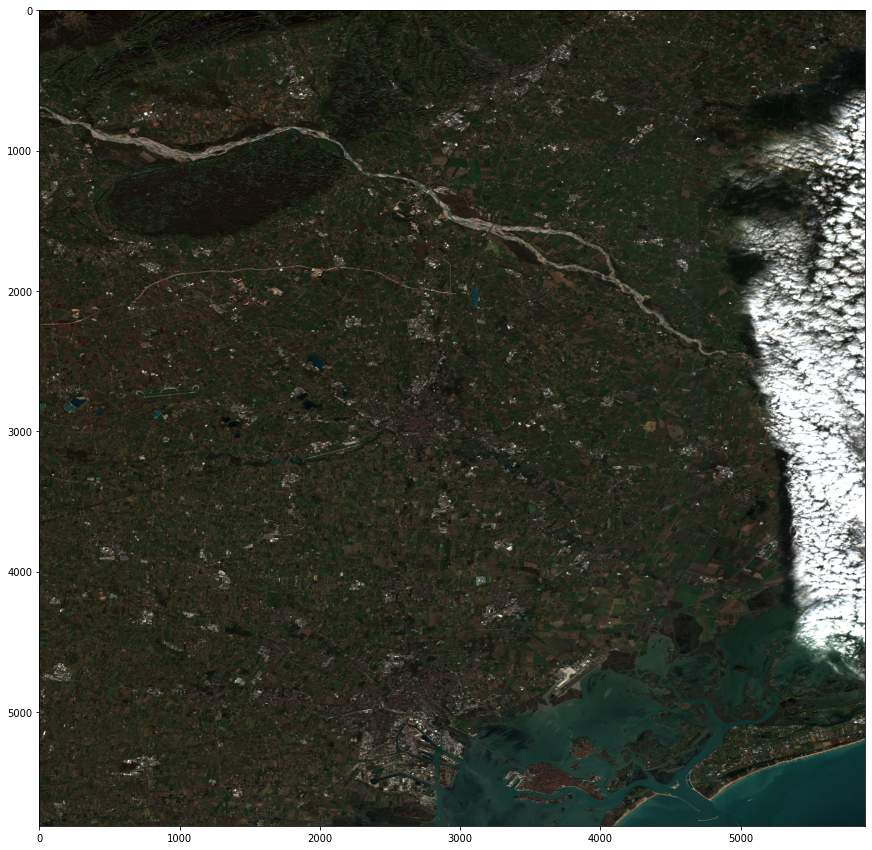

In [ ]:
plt.subplots(figsize=(15,15))
plt.imshow(4*rgb)

In [ ]:
obj = riox.open_rasterio(s2_filepath)

In [ ]:
obj.coords

Coordinates:
  * band         (band) int64 1 2 3 4 5
  * x            (x) float64 12.0 12.0 12.0 12.0 ... 12.53 12.53 12.53 12.53
  * y            (y) float64 45.93 45.93 45.93 45.93 ... 45.41 45.41 45.41 45.41
    spatial_ref  int64 0

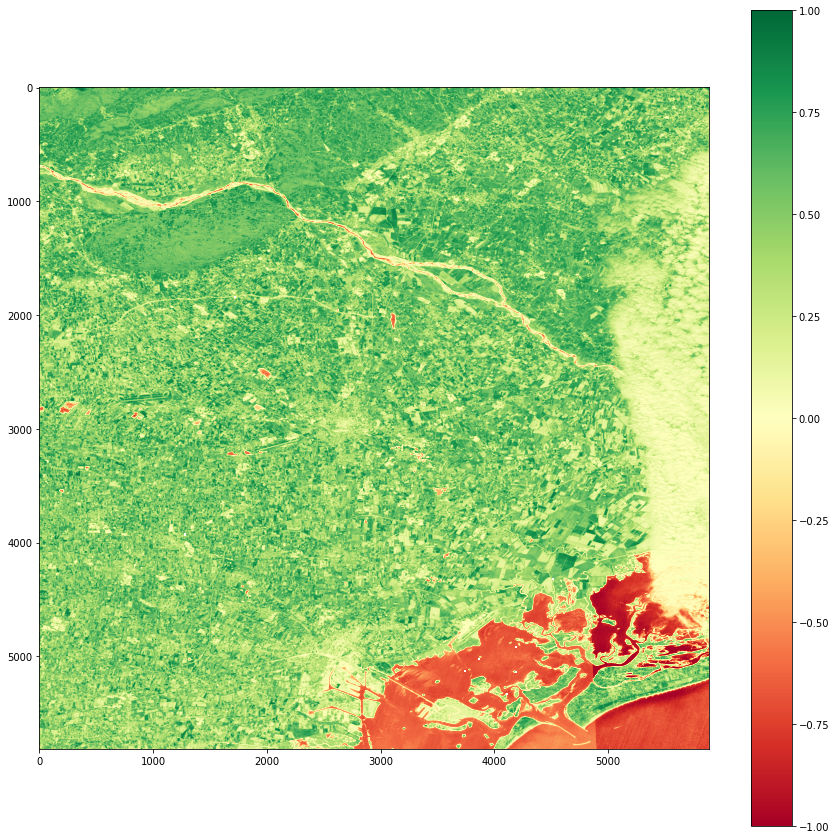

In [ ]:
plt.subplots(figsize=(15,15))
plt.imshow(ndvi, cmap='RdYlGn', vmin=-1, vmax =1)
plt.colorbar();

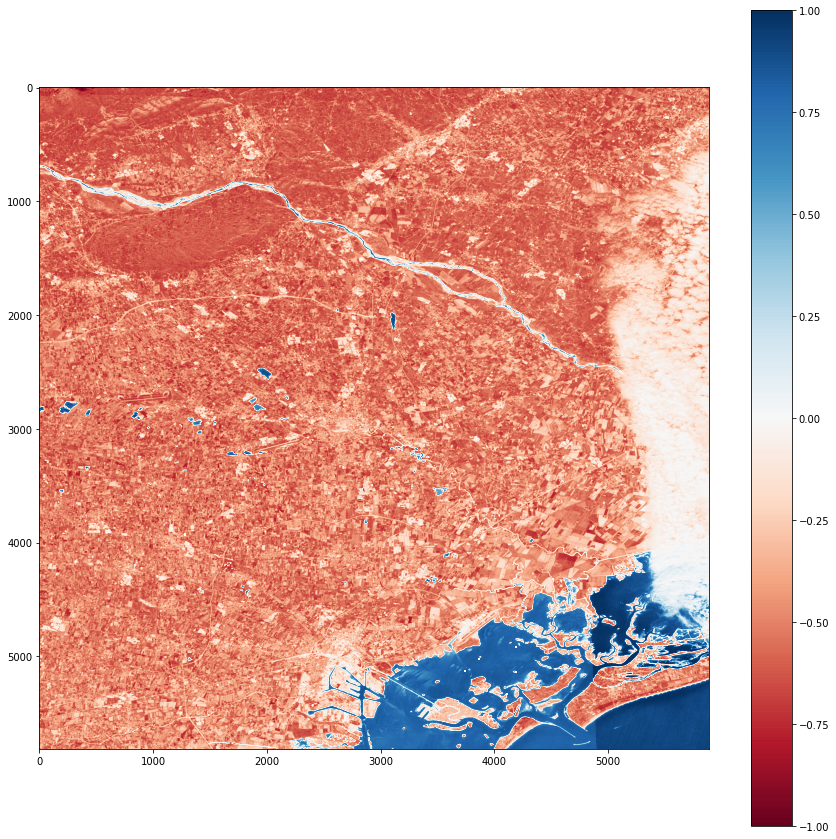

In [ ]:
plt.subplots(figsize=(15,15))
plt.imshow(ndwi, cmap='RdBu', vmin=-1, vmax =1)
plt.colorbar();

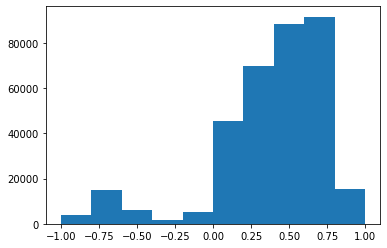

In [ ]:
plt.hist(ndvi.data[::10,::10].ravel());

In [ ]:
s2_raster.dtype

dtype('float64')

In [ ]:
fname = 'IndusValleyAg_20210128T060101'

In [ ]:
date = fname.split('_')[1].split('T')[0]

In [ ]:
f"{date[6:8]} {date[4:6]} {date[0:4]}"

'28 01 2021'